# <strong>🏛️ Discover Jordan: Classifying Heritage Sites Using Deep Learning</strong>


## Introduction

Jordan is home to some of the most remarkable heritage sites in the world including Petra, Jerash, the Dead Sea, and Wadi Rum. These landmarks are not only of historical and cultural importance but also attract millions of tourists each year. Preserving and promoting these sites is vital for education, tourism, and national identity.

In this project, we leverage deep learning techniques to build an image classification model capable of recognizing and classifying images of heritage sites in Jordan. Using a pre-trained convolutional neural network (CNN), we fine-tune the model on a custom dataset containing labeled images of seven key heritage locations.

This project aims to demonstrate how AI can support cultural heritage preservation and digital tourism by enabling automated recognition of important sites through computer vision.


## **Data preprocessing**

## Import Libraries

In [ ]:
from osgeo import gdal
import numpy as np
import random
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models


##Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The Dataset

In [ ]:
folders_path = '/content/drive/MyDrive/IMAGES'
split_dir = '/content/drive/MyDrive/Dataset_Split'
folders = ['train', 'val', 'test']


In [ ]:
classes = sorted(os.listdir(folders_path))

dict_class = {class_name: idx for idx, class_name in enumerate(classes)}

print(dict_class)

{'Dead_Sea': 0, 'Petra': 1, 'Roman_Theater': 2, 'Wadi_Rum': 3, 'ajloun': 4, 'dana': 5, 'jarash': 6}


In [ ]:
target_size = (224, 224)

class_names = sorted(os.listdir(folders_path))
class_to_label = {name: idx for idx, name in enumerate(class_names)}

images_data = []
labels_data = []

for class_name in class_names:
    class_folder = os.path.join(folders_path, class_name)
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        image = cv2.imread(image_path)

        if image is not None:
            image = cv2.resize(image, target_size)
            images_data.append(image)
            labels_data.append(class_to_label[class_name])

images_data = np.array(images_data)
labels_data = np.array(labels_data)

# Print dataset shape info
print(f"Images shape: {images_data.shape}")
print(f"Labels shape: {labels_data.shape}")

Images shape: (206, 224, 224, 3)
Labels shape: (206,)


In [ ]:
#Check if there are any damaged or unreadable images.
def check_images(folder):
    corrupted_files = []
    valid_count = 0
    for root, _, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    img.verify()  # Verify image integrity
                valid_count += 1
            except Exception:
                corrupted_files.append(path)
    return valid_count, corrupted_files


for folder in folders:
    folder_path = os.path.join(split_dir, folder)
    total_images, corrupted_files = check_images(folder_path)
    print(f"Number of valid images in '{folder}': {total_images}")
    if corrupted_files:
        print(f"Corrupted or unsupported files in '{folder}':")
        for file_path in corrupted_files:
            print(f" - {file_path}")
    else:
        print(f"No corrupted or unsupported files found in '{folder}'.")
    print('-' * 40)

Number of valid images in 'train': 182
No corrupted or unsupported files found in 'train'.
----------------------------------------
Number of valid images in 'val': 64
No corrupted or unsupported files found in 'val'.
----------------------------------------
Number of valid images in 'test': 82
No corrupted or unsupported files found in 'test'.
----------------------------------------


## Prepare image data for model training, validation, and testing using the image_dataset_from_directory function from the TensorFlow library.

In [ ]:
IMG_SIZE = (224, 224)  # Target image size
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Dataset_Split/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Dataset_Split/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Dataset_Split/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

Found 182 files belonging to 7 classes.
Found 64 files belonging to 7 classes.
Found 82 files belonging to 7 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])


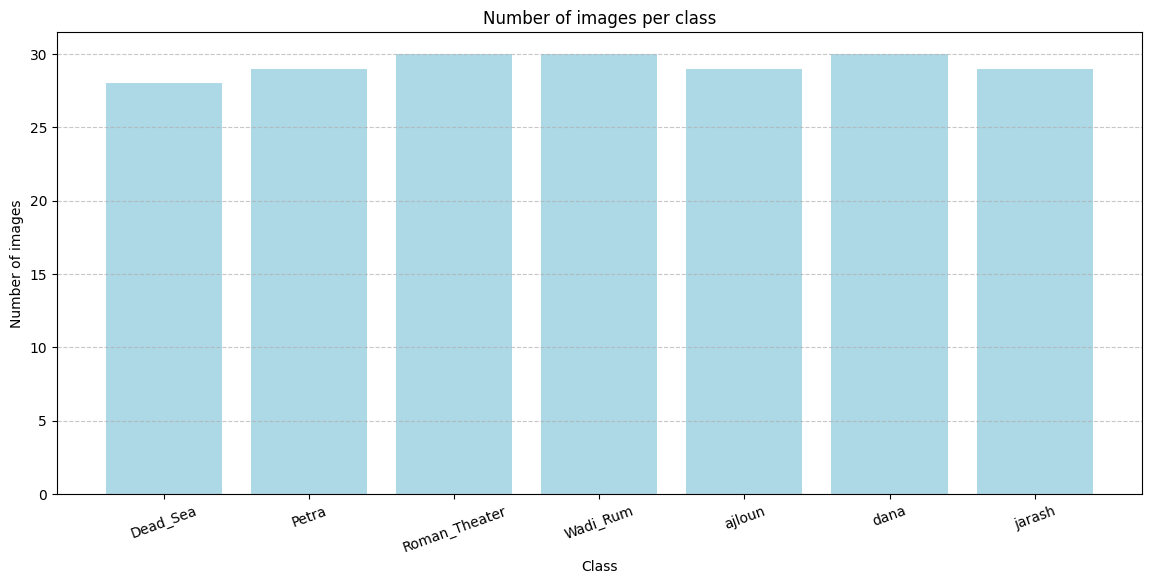

In [ ]:
#Balance or imbalance check
classes = sorted(os.listdir(folders_path))

counts = []
for class_name in classes:
    class_folder = os.path.join(folders_path, class_name)
    images_count = len([f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    counts.append(images_count)

plt.figure(figsize=(14, 6))
plt.bar(classes, counts, color='#add8e6')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.xticks(rotation=20)
plt.show()


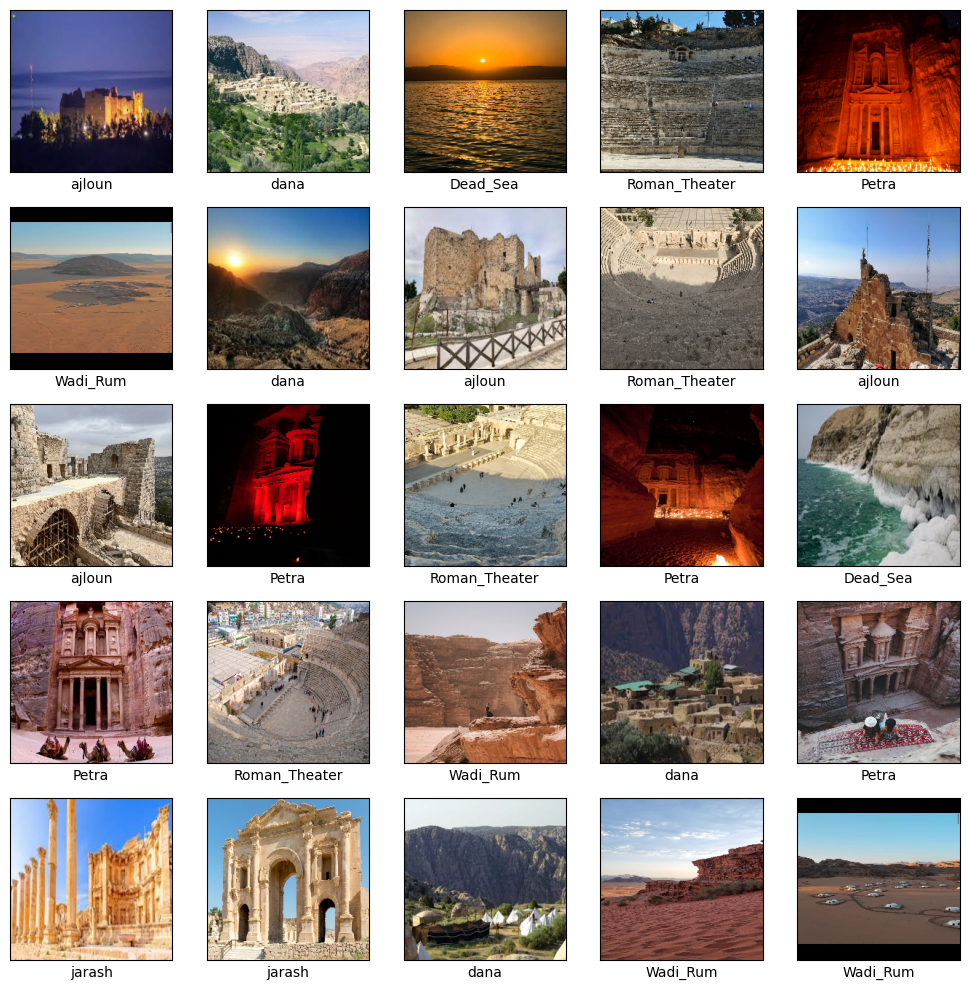

In [ ]:
#Show random images
dict_class_inv = {v: k for k, v in dict_class.items()}

plt.figure(figsize=(10, 10))

num_images_to_display = 25
random_indices = random.sample(range(len(images_data)), num_images_to_display)

for i, index in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_rgb = cv2.cvtColor(images_data[index], cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

    correct_label = labels_data[index]
    plt.xlabel(dict_class_inv[correct_label])

plt.tight_layout()
plt.show()


# **Prtrained Model**

We used the ResNet50 model pre-trained on the popular ImageNet dataset. This model is deep and effective at extracting features from images, helping to improve the accuracy of heritage landmark classification in Jordan.

In [ ]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(7, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
EPOCHS = 15

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 76s 11s/step - accuracy: 0.2146 - loss: 2.3992 - val_accuracy: 0.5781 - val_loss: 1.4618
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 77s 10s/step - accuracy: 0.5171 - loss: 1.3833 - val_accuracy: 0.8281 - val_loss: 0.7084
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 10s/step - accuracy: 0.7101 - loss: 0.8741 - val_accuracy: 0.8750 - val_loss: 0.4576
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 77s 9s/step - accuracy: 0.7957 - loss: 0.6689 - val_accuracy: 0.8438 - val_loss: 0.4411
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 89s 10s/step - accuracy: 0.8697 - loss: 0.4507 - val_accuracy: 0.9062 - val_loss: 0.3327
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 100s 14s/step - accuracy: 0.8377 - loss: 0.3775 - val_accuracy: 0.9375 - val_loss: 0.2271
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 64s 10s/step - accuracy: 0.9244 - loss: 0.2584 - val_accuracy: 0.9375 - val_loss: 0.2091
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 60s 10s/step - accuracy: 0.9419 - loss: 0.2446 - val_accuracy: 0.9531 - val_loss: 0.2156


In [ ]:
loss, accuracy = model.evaluate(test_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9761 - loss: 0.1037
Test Loss: 0.1084
Test Accuracy: 0.9756


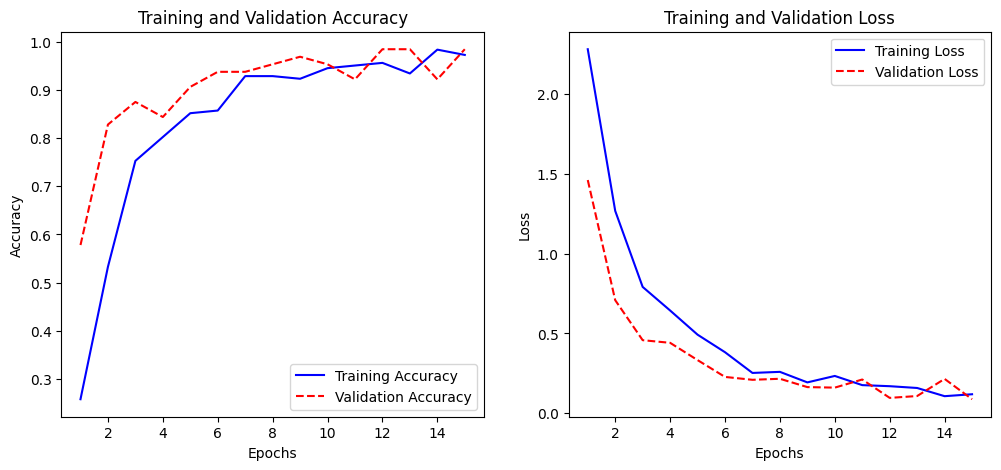

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# رسم accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# رسم loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



# **Fine tuning**

In [ ]:
print(len(base_model.layers))


175


In [ ]:
base_model.trainable = True

fine_tune_at = 130

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
fine_tune_epochs = 15
initial_epochs = EPOCHS
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)


Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 115s 15s/step - accuracy: 0.9003 - loss: 0.3671 - val_accuracy: 0.9844 - val_loss: 0.0847
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 139s 15s/step - accuracy: 0.8085 - loss: 0.5273 - val_accuracy: 0.9844 - val_loss: 0.0838
Epoch 17/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 142s 15s/step - accuracy: 0.9233 - loss: 0.2615 - val_accuracy: 0.9844 - val_loss: 0.0851
Epoch 18/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 87s 15s/step - accuracy: 0.9644 - loss: 0.1746 - val_accuracy: 0.9844 - val_loss: 0.0883
Epoch 19/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 143s 15s/step - accuracy: 0.9465 - loss: 0.1994 - val_accuracy: 0.9844 - val_loss: 0.0868
Epoch 20/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 142s 15s/step - accuracy: 0.9300 - loss: 0.2110 - val_accuracy: 0.9844 - val_loss: 0.0811
Epoch 21/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 87s 15s/step - accuracy: 0.9512 - loss: 0.1782 - val_accuracy: 0.9844 - val_loss: 0.0773
Epoch 22/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 143s 15s/step - accuracy: 0.9287 - loss: 0.1877 - val_accuracy: 0.9844 - val

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9822 - loss: 0.0707
Test Loss: 0.0567
Test Accuracy: 0.9878


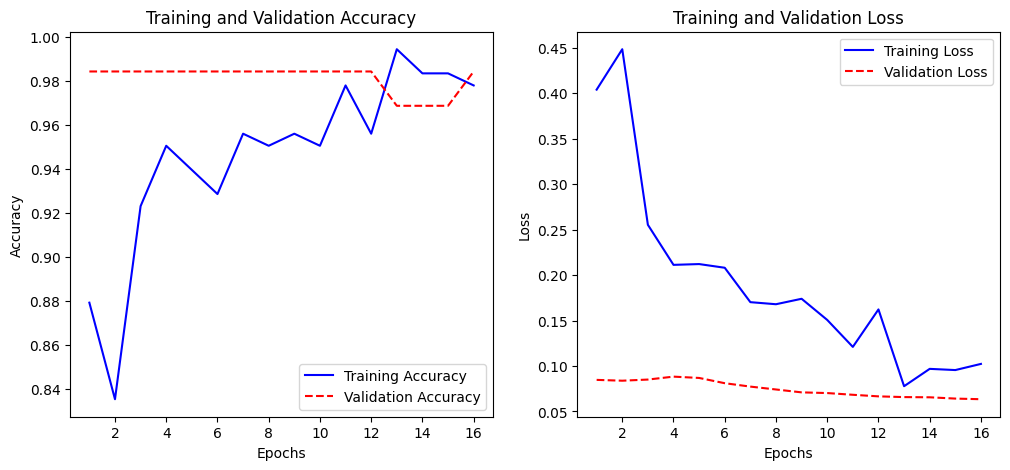

In [ ]:
import matplotlib.pyplot as plt

acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
